In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.1 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
tf.config.list_physical_devices('GPU')
tf.config.experimental.enable_op_determinism()
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
SEED = 7
tf.random.set_seed(SEED)

datos = pd.read_csv("/content/sample_data/Temp_Asu20092021 (2).csv")

datos['Fecha'] = pd.to_datetime(datos['Fecha'])


datos.set_index('Fecha', inplace=True)
datos = datos[datos.index.year >= 2019]
datos.dropna(inplace=True)

datos_interpolados = datos.resample('H').interpolate(method='spline', order=3)
datos_interpolados.dropna(inplace=True)


max_temperaturas_diarias = datos_interpolados.resample('D').max()['Temperatura']
datos_interpolados['Max_Temperatura_Dia'] = datos_interpolados.groupby(datos_interpolados.index.date)['Temperatura'].transform('max')

cuartiles = max_temperaturas_diarias.quantile([0.25, 0.5, 0.75])

umbral_frio = cuartiles[0.25]
umbral_bueno = cuartiles[0.5]
umbral_caliente = cuartiles[0.75]

datos_interpolados['Categoria_Temperatura'] = pd.cut(datos_interpolados['Temperatura'],
                                                     bins=[-float('inf'), umbral_frio, umbral_bueno,
                                                           umbral_caliente, float('inf')],
                                                     labels=['Frío', 'Bueno', 'Caliente', 'Muy Caliente'])

datos_interpolados['Temperatura_Siguiente_Dia'] = datos_interpolados['Categoria_Temperatura'].shift(-24)


datos_codificados = pd.get_dummies(datos_interpolados, columns=['Categoria_Temperatura'])





X = datos_interpolados[['Temperatura', 'Max_Temperatura_Dia']]
y = datos_codificados[['Categoria_Temperatura_Frío', 'Categoria_Temperatura_Bueno',
                       'Categoria_Temperatura_Caliente', 'Categoria_Temperatura_Muy Caliente']]

scaler = StandardScaler()
X_escalado = scaler.fit_transform(X)

indices_entrenamiento = (datos_interpolados.index.year <= 2019)
indices_validacion = ((datos_interpolados.index.year >= 2020) & (datos_interpolados.index.year <= 2020))

X_entrenamiento, X_validacion = X_escalado[indices_entrenamiento], X_escalado[indices_validacion]
y_entrenamiento, y_validacion = y.values[indices_entrenamiento], y.values[indices_validacion]



def objetivo(trial):
    num_capas = trial.suggest_categorical('num_capas', [1, 2, 3])
    num_unidades = trial.suggest_categorical('num_unidades', [32, 64, 128])
    tasa_aprendizaje = trial.suggest_loguniform('tasa_aprendizaje', 1e-4, 1e-2)

    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X.shape[1],)))
    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))
    modelo.add(Dense(4, activation='softmax'))


    modelo.compile(optimizer=Adam(learning_rate=tasa_aprendizaje),
                   loss=CategoricalCrossentropy(),
                   metrics=['accuracy'])


    modelo.fit(X_entrenamiento, y_entrenamiento, epochs=50, batch_size=32, verbose=0)


    _, val_acc = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_acc

estudio = optuna.create_study(direction='maximize')
estudio.optimize(objetivo, n_trials=10)

mejor_num_capas = 1
mejor_num_unidades = estudio.best_params['num_unidades']
mejor_tasa_aprendizaje = estudio.best_params['tasa_aprendizaje']

print("Mejores Hiperparámetros:")
print("Número de Capas:", mejor_num_capas)
print("Número de Unidades:", mejor_num_unidades)
print("Tasa de Aprendizaje:", mejor_tasa_aprendizaje)


modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(4, activation='softmax'))

modelo_final.compile(optimizer=Adam(learning_rate=mejor_tasa_aprendizaje),
                     loss=CategoricalCrossentropy(),
                     metrics=['accuracy'])


indices_entrenamiento_final = (datos_interpolados.index.year < 2020)
indices_prueba_final = (datos_interpolados.index.year >= 2021)

X_entrenamiento, X_prueba = X_escalado[indices_entrenamiento_final], X_escalado[indices_prueba_final]
y_entrenamiento, y_prueba = y.values[indices_entrenamiento_final], y.values[indices_prueba_final]


modelo_final.fit(X_entrenamiento, y_entrenamiento, epochs=50, batch_size=32, verbose=1)


_, val_acc = modelo_final.evaluate(X_prueba, y_prueba, verbose=0)
print(val_acc)


y_pred = modelo_final.predict(X_prueba)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(np.argmax(y_prueba, axis=1), y_pred_classes, average='weighted')
recall = recall_score(np.argmax(y_prueba, axis=1), y_pred_classes, average='weighted')
f1 = f1_score(np.argmax(y_prueba, axis=1), y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



[I 2024-05-02 21:17:49,484] A new study created in memory with name: no-name-406f958e-6143-4dbd-8eaa-3603bef5f408
<ipython-input-9-aa5449d77607>:73: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tasa_aprendizaje = trial.suggest_loguniform('tasa_aprendizaje', 1e-4, 1e-2)
[I 2024-05-02 21:18:16,151] Trial 0 finished with value: 0.994421660900116 and parameters: {'num_capas': 2, 'num_unidades': 64, 'tasa_aprendizaje': 0.009273459601270205}. Best is trial 0 with value: 0.994421660900116.
[I 2024-05-02 21:18:44,642] Trial 1 finished with value: 0.9976093173027039 and parameters: {'num_capas': 3, 'num_unidades': 32, 'tasa_aprendizaje': 0.00798574716311011}. Best is trial 1 with value: 0.9976093173027039.
[I 2024-05-02 21:19:15,771] Trial 2 finished with value: 0.9849726557731628 and parameters: {'num_capas': 3, 'num_unidades': 128, '

Mejores Hiperparámetros:
Número de Capas: 1
Número de Unidades: 32
Tasa de Aprendizaje: 0.00798574716311011
Epoch 1/50
274/274 [==============================] - 1s 2ms/step - loss: 0.3158 - accuracy: 0.9048
Epoch 2/50
274/274 [==============================] - 1s 2ms/step - loss: 0.0949 - accuracy: 0.9757
Epoch 3/50
274/274 [==============================] - 1s 2ms/step - loss: 0.0633 - accuracy: 0.9841
Epoch 4/50
274/274 [==============================] - 1s 2ms/step - loss: 0.0512 - accuracy: 0.9854
Epoch 5/50
274/274 [==============================] - 1s 3ms/step - loss: 0.0465 - accuracy: 0.9844
Epoch 6/50
274/274 [==============================] - 1s 4ms/step - loss: 0.0410 - accuracy: 0.9862
Epoch 7/50
274/274 [==============================] - 1s 3ms/step - loss: 0.0363 - accuracy: 0.9892
Epoch 8/50
274/274 [==============================] - 1s 3ms/step - loss: 0.0328 - accuracy: 0.9897
Epoch 9/50
274/274 [==============================] - 1s 4ms/step - loss: 0.0305 - accuracy:

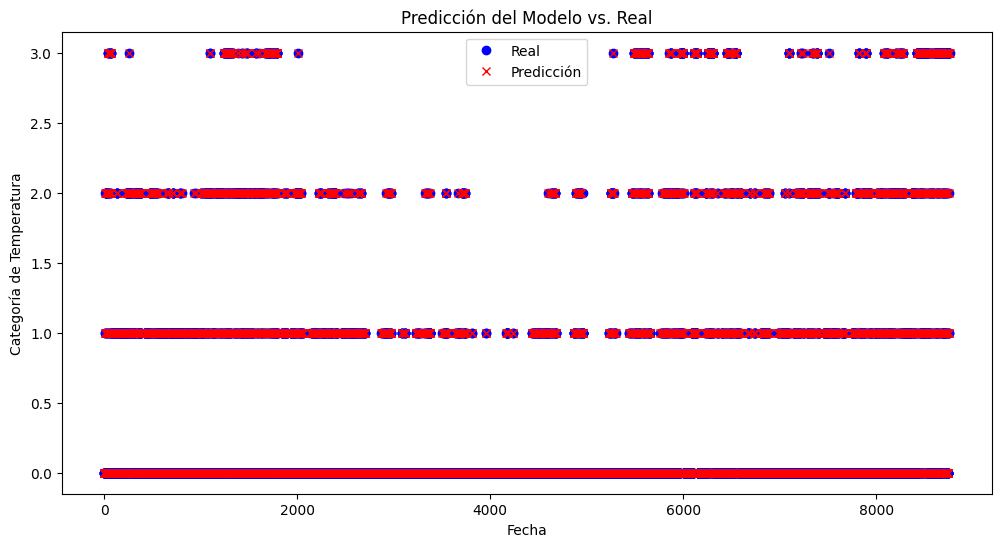

In [10]:
import matplotlib.pyplot as plt

y_prueba_df = pd.DataFrame(y_prueba, columns=y.columns)

# Graficar la predicción del modelo
plt.figure(figsize=(12, 6))
plt.plot(y_prueba_df.index, np.argmax(y_prueba_df.values, axis=1), label='Real', color='blue', marker='o', linestyle='None')
plt.plot(y_prueba_df.index, y_pred_classes, label='Predicción', color='red', marker='x', linestyle='None')
plt.title('Predicción del Modelo vs. Real')
plt.xlabel('Fecha')
plt.ylabel('Categoría de Temperatura')
plt.legend()
plt.show()